## Project

In [25]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Function to convert Indian Rupees to Euros and round to 2 decimal places
def inr_to_euro(price_inr, exchange_rate=0.011):
    price_inr = float(price_inr.replace('₹', '').replace(',', '').strip())
    price_euro = price_inr * exchange_rate
    return round(price_euro, 2)

def rsserr(a,b):
    '''
    Calculate the root of sum of squared errors. 
    a and b are numpy arrays
    '''
    return np.square(np.sum((a-b)**2))

def initiate_centroids(k, dset):
    '''
    Select k data points as centroids
    k: number of centroids
    dset: pandas dataframe
    '''
    centroids = dset.sample(k)
    return centroids

def centroid_assignation(dset, centroids):
    '''
    Given a dataframe `dset` and a set of `centroids`, we assign each
    data point in `dset` to a centroid. 
    - dset - pandas dataframe with observations
    - centroids - pa das dataframe with centroids
    '''
    k = centroids.shape[0]
    n = dset.shape[0]
    assignation = []
    assign_errors = []

    for obs in range(n):
        # Estimate error
        all_errors = np.array([])
        for centroid in range(k):
            err = rsserr(centroids.iloc[centroid, :], dset.iloc[obs,:])
            all_errors = np.append(all_errors, err)

        # Get the nearest centroid and the error
        nearest_centroid =  np.where(all_errors==np.amin(all_errors))[0].tolist()[0]
        nearest_centroid_error = np.amin(all_errors)

        # Add values to corresponding lists
        assignation.append(nearest_centroid)
        assign_errors.append(nearest_centroid_error)

    return assignation, assign_errors

def kmeans(dset, k=2, tol=1e-4):
    '''
    K-means implementationd for a 
    `dset`:  DataFrame with observations
    `k`: number of clusters, default k=2
    `tol`: tolerance=1E-4
    '''
    # Let us work in a copy, so we don't mess the original
    working_dset = dset.copy()
    # We define some variables to hold the error, the 
    # stopping signal and a counter for the iterations
    err = []
    goahead = True
    j = 0
    
    # Step 2: Initiate clusters by defining centroids 
    centroids = initiate_centroids(k, dset)

    while(goahead):
        # Step 3 and 4 - Assign centroids and calculate error
        working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids) 
        err.append(sum(j_err))
        
        # Step 5 - Update centroid position
        centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)

        # Step 6 - Restart the iteration
        if j>0:
            # Is the error less than a tolerance (1E-4)
            if err[j-1]-err[j]<=tol:
                goahead = False
        j+=1

    working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids)
    centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)
    return working_dset['centroid'], j_err, centroids


In [34]:
# Read the dataset
df = pd.read_csv('/Users/frottori/Documents/Code/Python/Big_Data_Python/Datasets/smartphones - smartphones.csv')
# Add a new column 'Price_Euro' with the converted prices as the third column
df.insert(2, 'Price_Euro', df['price'].apply(inr_to_euro))
 # colnames = list(df.columns[1:-1])
df['id'] = range(1, len(df) + 1)   # Add a unique identifier for each row
# Map the processor categories to integers
df['processor_int'] = df['processor'].astype('category').cat.codes
df.head()

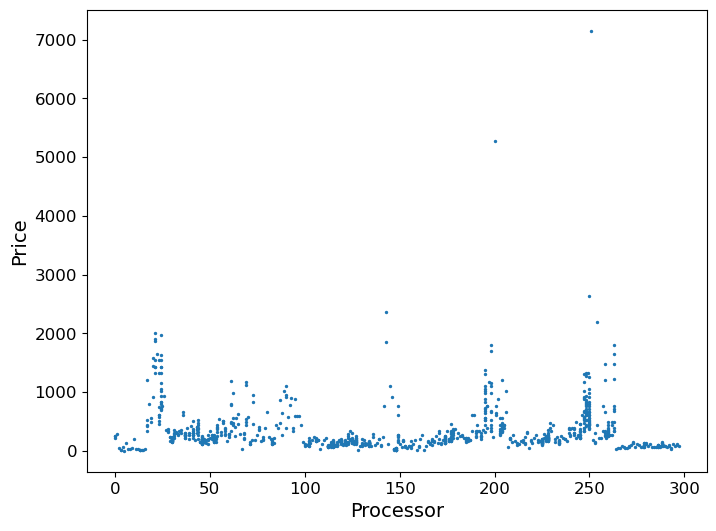

In [27]:
# Scatter plot of the data points
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x=df['processor_int'], y=df['Price_Euro'], s=2)
ax.set_xlabel(r'Processor', fontsize=14)
ax.set_ylabel(r'Price', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [28]:
# Apply the k-means algorithm to the dataset
np.random.seed(42)
k = 3 # Number of clusters (for low range processors, medium range processors, and high range processors)
df['centroid'], df['error'], centroids =  kmeans(df[['processor_int','Price_Euro']], k)
df.head()

,model,price,Price_Euro,rating,sim,processor,ram,battery,display,camera,card,os,id,processor_int,centroid,error
0,OnePlus 11 5G,"₹54,999",604.99,89.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Snapdragon 8 Gen2, Octa Core, 3.2 GHz Processor","12 GB RAM, 256 GB inbuilt",5000 mAh Battery with 100W Fast Charging,"6.7 inches, 1440 x 3216 px, 120 Hz Display wit...",50 MP + 48 MP + 32 MP Triple Rear & 16 MP Fron...,Memory Card Not Supported,Android v13,1,248,1,1.668418e+09
1,OnePlus Nord CE 2 Lite 5G,"₹19,989",219.88,81.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi","Snapdragon 695, Octa Core, 2.2 GHz Processor","6 GB RAM, 128 GB inbuilt",5000 mAh Battery with 33W Fast Charging,"6.59 inches, 1080 x 2412 px, 120 Hz Display wi...",64 MP + 2 MP + 2 MP Triple Rear & 16 MP Front ...,"Memory Card (Hybrid), upto 1 TB",Android v12,2,228,0,4.847132e+07
2,Samsung Galaxy A14 5G,"₹16,499",181.49,75.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi","Exynos 1330, Octa Core, 2.4 GHz Processor","4 GB RAM, 64 GB inbuilt",5000 mAh Battery with 15W Fast Charging,"6.6 inches, 1080 x 2408 px, 90 Hz Display with...",50 MP + 2 MP + 2 MP Triple Rear & 13 MP Front ...,"Memory Card Supported, upto 1 TB",Android v13,3,78,0,2.614023e+07
3,Motorola Moto G62 5G,"₹14,999",164.99,81.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi","Snapdragon 695, Octa Core, 2.2 GHz Processor","6 GB RAM, 128 GB inbuilt",5000 mAh Battery with Fast Charging,"6.55 inches, 1080 x 2400 px, 120 Hz Display wi...",50 MP + 8 MP + 2 MP Triple Rear & 16 MP Front ...,"Memory Card (Hybrid), upto 1 TB",Android v12,4,177,0,5.290350e+06
4,Realme 10 Pro Plus,"₹24,999",274.99,82.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi","Dimensity 1080, Octa Core, 2.6 GHz Processor","6 GB RAM, 128 GB inbuilt",5000 mAh Battery with 67W Fast Charging,"6.7 inches, 1080 x 2412 px, 120 Hz Display wit...",108 MP + 8 MP + 2 MP Triple Rear & 16 MP Front...,Memory Card Not Supported,Android v13,5,41,0,2.708497e+08


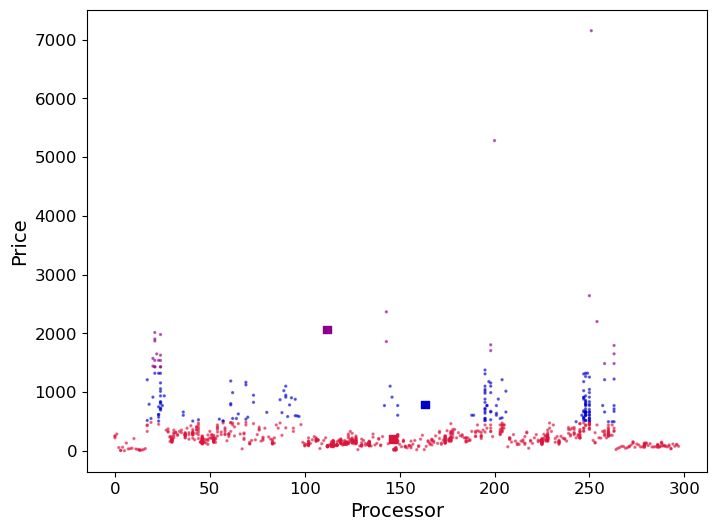

In [29]:
# Colors for the clusters in the scatter plot
customcmap = ListedColormap(["crimson", "mediumblue", "darkmagenta"])
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x=df['processor_int'], y=df['Price_Euro'],  marker = 'o', 
            c=df['centroid'].astype('category'), 
            cmap = customcmap, s=2, alpha=0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  
            marker = 's', s=30, c=[0, 1, 2], 
            cmap = customcmap)
ax.set_xlabel(r'Processor', fontsize=14)
ax.set_ylabel(r'Price', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [30]:
def assoc_rules(df):
    # Dataframe with all processor characteristics
    pr = pd.DataFrame(df['processor']);
    # Remove the thin space character
    pr = pr.replace('\u2009', '', regex=True)
    data = list(pr["processor"].apply(lambda x:x.split(",") ))

    te = TransactionEncoder()
    te_data = te.fit(data).transform(data)
    pr = pd.DataFrame(te_data,columns=te.columns_)

    # Apriori function to extract frequent itemsets for association rule mining
    # Support threshold can be mentioned to retrieve frequent itemset
    freq_items = apriori(pr, min_support = 0.1, use_colnames = True, verbose = 1)

    # Association rule mining
    #Let's view our interpretation values using the Associan rule function.
    #Function to generate association rules from frequent itemsets
    pr_ar = association_rules(freq_items, metric = "confidence", min_threshold = 0.6)
    return freq_items, pr_ar

In [31]:
# Association rules for each cluster
df0 = df[df['centroid'] == 0]
freq_items, pr_ar = assoc_rules(df0)
freq_items.head()
pr_ar.head()

Processing 20 combinations | Sampling itemset size 2


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,( 2.2GHz Processor),( Octa Core),0.162651,0.873494,0.161446,0.992593,1.136347,0.019371,17.078313,0.143294
1,( 2.3GHz Processor),( Octa Core),0.103614,0.873494,0.103614,1.000000,1.144828,0.013108,inf,0.141129
2,( 2.4GHz Processor),( Octa Core),0.151807,0.873494,0.151807,1.000000,1.144828,0.019205,inf,0.149148
3,( 2GHz Processor),( Octa Core),0.175904,0.873494,0.156627,0.890411,1.019367,0.002976,1.154367,0.023054


In [32]:
df1 = df[df['centroid'] == 1]
freq_items, pr_ar = assoc_rules(df1)
freq_items.head()
pr_ar.head()

Processing 4 combinations | Sampling itemset size 43


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,( 3.2GHz Processor),( Octa Core),0.319018,0.791411,0.319018,1.0,1.263566,0.066544,inf,0.306306
1,(Snapdragon 8 Gen2),( 3.2GHz Processor),0.128834,0.319018,0.128834,1.0,3.134615,0.087734,inf,0.781690
2,(Snapdragon 8+ Gen1),( 3.2GHz Processor),0.104294,0.319018,0.104294,1.0,3.134615,0.071023,inf,0.760274
3,( 3GHz Processor),( Octa Core),0.184049,0.791411,0.184049,1.0,1.263566,0.038391,inf,0.255639
4,(Snapdragon 8 Gen2),( Octa Core),0.128834,0.791411,0.128834,1.0,1.263566,0.026873,inf,0.239437


In [33]:
df2 = df[df['centroid'] == 2]
freq_items, pr_ar = assoc_rules(df2)
freq_items.head()
pr_ar.head()

Processing 4 combinations | Sampling itemset size 43


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,( 2.84GHz Processor),( Octa Core),0.148148,0.444444,0.148148,1.000000,2.25,0.082305,inf,0.652174
1,(Snapdragon 888),( 2.84GHz Processor),0.111111,0.148148,0.111111,1.000000,6.75,0.094650,inf,0.958333
2,( 2.84GHz Processor),(Snapdragon 888),0.148148,0.111111,0.111111,0.750000,6.75,0.094650,3.555556,1.000000
3,( 3.22GHz Processor),( Hexa Core),0.185185,0.222222,0.185185,1.000000,4.50,0.144033,inf,0.954545
4,( Hexa Core),( 3.22GHz Processor),0.222222,0.185185,0.185185,0.833333,4.50,0.144033,4.888889,1.000000
